Time Series Forecast with NHiTS on the Vierlinden dataset (all sensors, 2021)

In [1]:
import sys
sys.path.append('./pytorch-forecasting/')
import pandas as pd
import numpy as np
import torch
import lightning.pytorch as pl
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
import matplotlib.pyplot as plt
pl.seed_everything(42)

Global seed set to 42


42

### Load dataset

In [2]:
# Read the dataset into a DataFrame
data = pd.read_csv('./RIWWER/Vierlinden/Vierlinden_2021_All.csv')

# Drop columns that have lots of missing values
data.drop(["FLP_Hohenstand_Pumpensumpf_pval","FLP_Strom_P3_pval","FLP_Strom_P4_pval","FLP_Strom_P5_pval","Durchfluss SWP1 und SWP2_pval","FLP_Hohenstand_Becken1_pval","FLP_Hohenstand_Becken3_pval","FLP_Hohenstand_Beckne2_pval"], axis=1, inplace=True)

# NaNs are not allowed by the model
data.fillna(method="bfill", inplace=True)
data.fillna(method="ffill", inplace=True)

# Set Datetime as index
data['Datetime'] = pd.to_datetime(data['Datetime'])

# One time series for the whole year?
data['series'] = 0

# As many timesteps per timeseries as hours in every month?
time_idx = []
for i in range(1):
    timesteps = len( data[ data['series'] == i ] )
    time_idx += list(range(timesteps))
data['time_idx'] = time_idx

In [3]:
data.head()

,Datetime,Schieber Position_pval,Oberwasser_pval,Unterwasser_pval,Durchflumenge_pval,Berechnete Durchflussmenge_pval,Fllstand SWS_pval,Fllstand RWS_pval,Strom P1_pval,Strom P2_pval,...,Strom Pumpe 2_pval1,Strom Pumpe 3_pval,Niederschlag,Füllstand_RRB,Entleerung_RüB,Füllstand_RüB_1,Füllstand_RüB_2,Füllstand_RüB_3,series,time_idx
0,2021-01-01 00:00:00,100.0,8.140845,5.753623,7.689189,7.732558,75.717949,36.0,1.076923,0.0,...,0.0,1.0,0.000000,1.47,0.098,3.16,3.08,2.72,0,0
1,2021-01-01 01:00:00,100.0,8.000000,5.173913,6.808219,8.271739,75.717949,36.0,1.076923,0.0,...,0.0,1.0,1.182353,1.47,0.099,3.16,3.08,2.72,0,1
2,2021-01-01 02:00:00,100.0,7.967742,5.000000,5.813333,7.197674,75.717949,36.0,1.076923,0.0,...,0.0,1.0,1.182353,1.47,0.096,3.16,3.08,2.72,0,2
3,2021-01-01 03:00:00,100.0,7.076923,4.843750,4.216216,4.743243,75.717949,36.0,1.076923,0.0,...,0.0,1.0,1.182353,1.47,0.098,3.16,3.08,2.72,0,3
4,2021-01-01 04:00:00,100.0,8.464789,5.466667,8.384615,8.325000,75.717949,36.0,1.076923,0.0,...,0.0,1.0,1.182353,1.47,0.098,3.16,3.08,2.72,0,4


In [4]:
# Parameters for dataloaders
max_encoder_length = 24*2
max_prediction_length = 5*2
training_cutoff = data["time_idx"].max() * 4 // 5 # 80% for training
context_length = max_encoder_length
prediction_length = max_prediction_length
batch_size = 32

In [5]:
# Load best model
best_model_path = './RIWWER/torch_forecasting/model_checkpoints/TFT_Vierlinden_saved_datasets/lightning_logs/version_6/checkpoints/epoch=40-step=6150.ckpt'
best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer_new/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer_new/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


### Corrupt sensor clusters

In [6]:
validation = TimeSeriesDataSet(
        data[lambda x: x.time_idx > training_cutoff],
        target_normalizer="auto",
        time_idx="time_idx",
        target="Entleerung_RüB",
        categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
        group_ids=["series"],
        time_varying_unknown_reals=list(set(data.columns) - {'Datetime', 'series', 'time_idx'}),
        time_varying_known_reals=['time_idx'], # needed for TFT
        max_encoder_length=context_length,
        min_encoder_length=max_encoder_length,
        max_prediction_length=prediction_length,
        min_prediction_length=max_prediction_length,
        allow_missing_timesteps=True
        )
validation = validation.load('./RIWWER/Vierlinden/val_set_with_timeidx')

In [7]:
validation.data['reals']

tensor([[ 1.7086, -0.0663,  0.1037,  ..., -0.3601, -0.2640, -0.4271],
        [ 1.7091, -0.0663,  0.1037,  ..., -0.3601, -0.2640, -0.4377],
        [ 1.7096, -0.0663,  0.1037,  ..., -0.3601, -0.2640, -0.3778],
        ...,
        [ 2.5968, -0.0663, -0.2790,  ..., -0.3601, -0.2004, -0.4589],
        [ 2.5973, -0.0663, -0.2790,  ..., -0.3601, -0.2004, -0.3558],
        [ 2.5978, -0.0663, -0.2790,  ..., -0.3601, -0.2004, -0.4396]])

In [9]:
# Evaluate before corrupting sensors
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=18)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to(torch.device('cuda:0'))
predictions = best_model.predict(val_dataloader,
                                 trainer_kwargs=dict(default_root_dir="./RIWWER/torch_forecasting/model_checkpoints/TFT_Vierlinden_saved_datasets"))
print('No sensors shut down.')
err = actuals - predictions
mae = err.abs().mean()
print('MAE = ' + str(mae))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No sensors shut down.
MAE = tensor(1.3089, device='cuda:0')


In [10]:
mae_trace = []
for i in range(len(validation.data['reals'][0])):
    validation.data['reals'][:, i] = 0.0

    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=18)

    ### Make prediction and evaluate ###
    predictions = best_model.predict(val_dataloader,
                                     trainer_kwargs=dict(default_root_dir="./RIWWER/torch_forecasting/model_checkpoints/TFT_Vierlinden_saved_datasets"))
    print(str(i+1) + ' sensors shut down.')
    err = actuals - predictions
    mae = err.abs().mean()
    mae_trace.append(mae)
    #print('MAE = ' + str(mae))
    #rmse = torch.sqrt( torch.square(err).mean() )
    #print('RMSE = ' + str(rmse))
    #del val_dataloader

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


1 sensors shut down.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


2 sensors shut down.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


3 sensors shut down.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


4 sensors shut down.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


5 sensors shut down.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


6 sensors shut down.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


7 sensors shut down.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


8 sensors shut down.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


9 sensors shut down.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


10 sensors shut down.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


11 sensors shut down.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


12 sensors shut down.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


13 sensors shut down.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


14 sensors shut down.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


15 sensors shut down.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


16 sensors shut down.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


17 sensors shut down.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


18 sensors shut down.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


19 sensors shut down.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


20 sensors shut down.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


21 sensors shut down.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


22 sensors shut down.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


23 sensors shut down.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


24 sensors shut down.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


25 sensors shut down.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


26 sensors shut down.
27 sensors shut down.


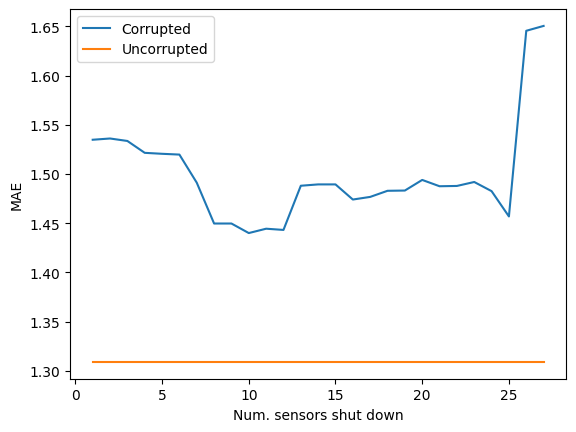

In [11]:
plt.plot(np.arange(1, len(mae_trace)+1), [m.cpu() for m in mae_trace])
plt.plot(np.arange(1, len(mae_trace)+1), [1.3089]*len(mae_trace))
plt.xlabel('Num. sensors shut down')
plt.ylabel('MAE')
plt.legend(['Corrupted', 'Uncorrupted'])
plt.show()